In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.pyplot as plt

square_large_train size:  2000
steps_large_train size:  20000
multimodal_large_train size:  20000


<Axes: >

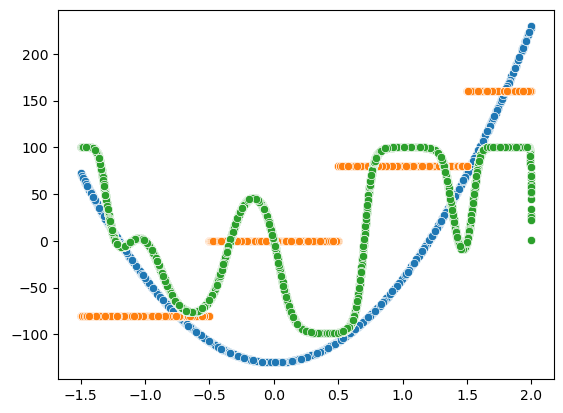

In [26]:
square_large_train = pd.read_csv('../data/regression/square-large-training.csv')[['x', 'y']]
steps_large_train = pd.read_csv('../data/regression/steps-large-training.csv')[['x', 'y']]
multimodal_large_train = pd.read_csv('../data/regression/multimodal-large-training.csv')[['x', 'y']]

square_large_test = pd.read_csv('../data/regression/square-large-test.csv')[['x', 'y']]
steps_large_test = pd.read_csv('../data/regression/steps-large-test.csv')[['x', 'y']]
multimodal_large_test = pd.read_csv('../data/regression/multimodal-large-test.csv')[['x', 'y']]

square_large_train_X = np.array(square_large_train['x'])
square_large_train_Y = np.array(square_large_train['y'])

square_large_test_X = np.array(square_large_test['x'])
square_large_test_Y = np.array(square_large_test['y'])

steps_large_train_X = np.array(steps_large_train['x'])
steps_large_train_Y = np.array(steps_large_train['y'])

steps_large_test_X = np.array(steps_large_test['x'])
steps_large_test_Y = np.array(steps_large_test['y'])

multimodal_large_train_X = np.array(multimodal_large_train['x'])
multimodal_large_train_Y = np.array(multimodal_large_train['y'])

multimodal_large_test_X = np.array(multimodal_large_test['x'])
multimodal_large_test_Y = np.array(multimodal_large_test['y'])

print('square_large_train size: ', square_large_train.size)
print('steps_large_train size: ', steps_large_train.size)
print('multimodal_large_train size: ', multimodal_large_train.size)

sns.scatterplot(x=square_large_train_X, y=square_large_train_Y)
sns.scatterplot(x=steps_large_train_X, y=steps_large_train_Y)
sns.scatterplot(x=multimodal_large_train_X, y=multimodal_large_train_Y)

In [142]:
def sigmoid(x):
	return 1/(1+np.e**(-x))

def sigmoid_derivative(x):
	return sigmoid(x) * (1 - sigmoid(x))

def linear(x):
	return x

def linear_derivative(x):
	return 1

class network:
	def __init__(self, architecture, activation_functions, activation_derivatives, initiation_method):
		self.architecture = architecture
		self.activation_functions = activation_functions
		self.activation_derivatives = activation_derivatives
		self.weights_biases_initiation(initiation_method)
		self.mse_record = []

	def set_state(self, architecture, biases, weights, activation_functions):
		self.architecture = architecture
		self.biases = biases
		self.weights = weights
		self.activation_functions = activation_functions

	def weights_biases_initiation(self, initiation_method):
		self.weights = [None]
		self.biases = [None]
		self.weights_momentum = [None]
		self.biases_momentum = [None]
		self.weigths_rmsProp = [None]
		self.biases_rmsProp = [None]

		if initiation_method not in ['he', 'xavier', 'uniform']:
			print('Initiation method incorrect!')
			return 

		for i in range(len(self.architecture) - 1):
			input_dim = self.architecture[i]
			output_dim = self.architecture[i + 1]
			
			if initiation_method == 'he':
				weight_matrix = np.random.randn(input_dim, output_dim) * np.sqrt(2 / input_dim)
			elif initiation_method == 'xavier':
				weight_matrix = np.random.randn(input_dim, output_dim) * np.sqrt(1 / input_dim)
			elif initiation_method == 'uniform':
				weight_matrix = np.random.uniform(0, 1, (input_dim, output_dim))

			bias_vector = np.zeros((1, output_dim))
			
			self.weights_momentum.append(np.zeros(weight_matrix.shape))
			self.biases_momentum.append(np.zeros(bias_vector.shape))
			self.weigths_rmsProp.append(np.zeros(weight_matrix.shape))
			self.biases_rmsProp.append(np.zeros(bias_vector.shape))
			self.weights.append(weight_matrix)
			self.biases.append(bias_vector)

	def forward(self, X):
		# as a convention, for convinience, zeroth index of activations is raw input, i add None to preactivations for uniform indexing
		self.activations = [X]
		self.preactivations = [None]

		for i in range(0, len(self.architecture)-1):
			z = np.dot(self.activations[i], self.weights[i+1]) + self.biases[i+1]
			self.preactivations.append(z)
			
			a = self.activation_functions[i+1](z)
			self.activations.append(a)
	
	def check_MSE(self, x, y):
		self.forward(x)
		prediction = self.destandardize_data(self.activations[-1], 'y')
		correct = self.destandardize_data(y, 'y')
		return np.mean((correct - prediction) ** 2)
	
	def visualize_network(self):
		G = nx.DiGraph()
		pos = {}
		edge_colors = []
		edge_widths = []
		
		for layer_idx, num_nodes in enumerate(self.architecture):
			for node_idx in range(num_nodes):
				node_name = f"L{layer_idx}_N{node_idx}"
				pos[node_name] = (layer_idx, -node_idx)  
				G.add_node(node_name)
				
				if layer_idx > 0: 
					for prev_idx in range(self.architecture[layer_idx - 1]):
						prev_name = f"L{layer_idx-1}_N{prev_idx}"
						weight = self.weights[layer_idx][prev_idx][node_idx]

						if weight != 0:
							G.add_edge(prev_name, node_name)
							edge_colors.append('red' if weight < 0 else 'green')
							edge_widths.append(np.log(abs(weight)))
		
		plt.figure(figsize=(10, 5))
		nx.draw(G, pos, with_labels=True, node_size=700, node_color="skyblue", edge_color=edge_colors, width=edge_widths)
		plt.show()

	def backward(self, Y):
		self.error = [None] * (len(self.weights))
		self.weights_gradient = [None] * (len(self.weights))
		self.biases_gradient = [None] * (len(self.weights))

		self.error[-1] = (self.activations[-1] - Y) * self.activation_derivatives[-1](self.preactivations[-1])
		for i in reversed(range(1, len(self.error) - 1)):
			self.error[i] = np.dot(self.error[i+1], self.weights[i+1].T) * self.activation_derivatives[i](self.preactivations[i])
		
		for i in range(1, len(self.error)):
			# self.weights_gradient[i] = -step * np.dot(self.activations[i-1].T, self.error[i]) / self.error[i].shape[0]
			# self.biases_gradient[i] = (-step * np.mean(self.error[i], axis=0)).reshape(1, -1)
			self.weights_gradient[i] = np.dot(self.activations[i-1].T, self.error[i]) / self.error[i].shape[0]
			self.biases_gradient[i] = (np.mean(self.error[i], axis=0)).reshape(1, -1)

	def prepeare_batches(self, data, batch_size=None):
		n = len(data)
		if batch_size == None:
			batch_number = 1
		else:
			batch_number = int(np.ceil(n / batch_size))

		data_shuffled = np.random.permutation(data)
		x = data_shuffled[:,0].reshape(n,1)
		y = data_shuffled[:,1].reshape(n,1)

		x = self.standardize_data(x, 'x')
		y = self.standardize_data(y, 'y')
		
		x = np.array_split(x, batch_number)
		y = np.array_split(y, batch_number)

		return x, y, batch_number
	
	def learn_old(self, x, y, step, iterations):
		x = self.standardize_data(x, 'x')
		y = self.standardize_data(y, 'y')

		for e in range(iterations):
			self.forward(x)
			self.backward(y, step)
			
			for i in range(1, len(self.architecture)):
					self.weights[i] += self.weights_gradient[i]
					self.biases[i] += self.biases_gradient[i]

			self.mse_record.append(self.check_MSE(x, y))

	def learn(self, data, epochs_number, step, momentum_dumping=None, rmsprop_dumping=None, batch_size=None):
		if momentum_dumping != None and rmsprop_dumping != None:
			print('Both momentum and rmsProp parameters were passed. Choose one.')
			return 
		
		for e in range(epochs_number):
			x, y, batch_number = self.prepeare_batches(data, batch_size)

			for b in range(batch_number):
				self.forward(x[b])
				self.backward(y[b])

				for i in range(1, len(self.architecture)):
					if momentum_dumping == None and rmsprop_dumping == None:
						# simple learning
						self.weights[i] -= self.weights_gradient[i] * step
						self.biases[i] -= self.biases_gradient[i] * step

					elif momentum_dumping != None and rmsprop_dumping == None:
						# learning with momentum
						self.weights_momentum[i] = self.weights_momentum[i] * momentum_dumping - self.weights_gradient[i]
						self.biases_momentum[i] = self.biases_momentum[i] * momentum_dumping - self.biases_gradient[i]
						self.weights[i] += self.weights_momentum[i] * step
						self.biases[i] += self.biases_momentum[i] * step

					elif momentum_dumping == None and rmsprop_dumping != None:
						# learning with rmsProp
						epsilon = 1e-8
						self.weigths_rmsProp[i] = rmsprop_dumping * self.weigths_rmsProp[i] + (1 - rmsprop_dumping) * self.weights_gradient[i]**2
						self.biases_rmsProp[i] = rmsprop_dumping * self.biases_rmsProp[i] + (1 - rmsprop_dumping) * self.biases_gradient[i]**2
						self.weights[i] -= step/(np.sqrt(self.weigths_rmsProp[i] + epsilon)) * self.weights_gradient[i]
						self.biases[i] -= step/(np.sqrt(self.biases_rmsProp[i] + epsilon)) * self.biases_gradient[i]

			self.mse_record.append(self.check_MSE(np.vstack(x), np.vstack(y)))

	def standardize_data(self, data, type):
		mean = np.mean(data, axis=0)
		std = np.std(data, axis=0)
		data_new = (data - mean) / std

		if type == 'x':
			self.standardize_params_x = (mean, std)
		if type == 'y':
			self.standardize_params_y = (mean, std)

		return data_new

	def destandardize_data(self, data, type):
		if type == 'x':
			return data * self.standardize_params_x[1] + self.standardize_params_x[0]
		if type == 'y':
			return data * self.standardize_params_y[1] + self.standardize_params_y[0]

def test(x, y, size, network):
	x = x.reshape(size, 1)
	y = y.reshape(size, 1)
	x_std = (x - network.standardize_params_x[0]) / network.standardize_params_x[1]
	
	network.forward(x_std)
	y_pred_std = network.activations[-1]
	y_pred = network.destandardize_data(y_pred_std, 'y')

	print('test mse:', np.mean((y - y_pred) ** 2))
	sns.scatterplot(x=x.flatten(), y=y_pred.flatten(), alpha=0.8, label='Predicted')
	sns.scatterplot(x=x.flatten(), y=y.flatten(), alpha=0.8, label='Actual')

In [173]:
network_151_square_rms = network(np.array([1, 5, 1]), [None, sigmoid, linear], [None, sigmoid_derivative, linear_derivative], 'xavier')
network_151_square_mom = network(np.array([1, 5, 1]), [None, sigmoid, linear], [None, sigmoid_derivative, linear_derivative], 'xavier')

In [174]:
network_151_square_rms.learn(square_large_train, 1500, 0.015, rmsprop_dumping=0.95, batch_size=15)
network_151_square_mom.learn(square_large_train, 1500, 0.025, momentum_dumping=0.8, batch_size=15)

Final mse RMSprop:  0.9742467303347344
Final mse momentum:  0.4119774631221969


<Axes: >

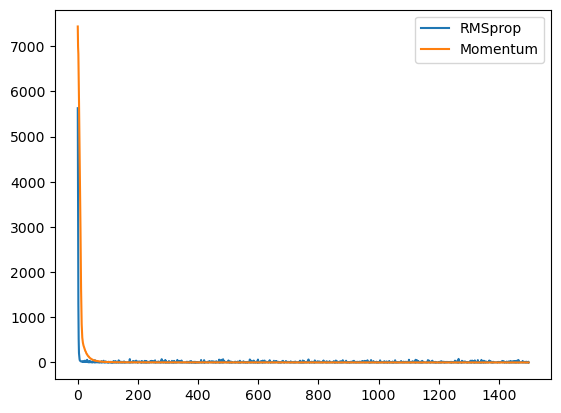

In [175]:
print('Final mse RMSprop: ', network_151_square_rms.mse_record[-1])
print('Final mse momentum: ', network_151_square_mom.mse_record[-1])
sns.lineplot(network_151_square_rms.mse_record, label = 'RMSprop')
sns.lineplot(network_151_square_mom.mse_record, label = 'Momentum')

test mse: 185.7985869042097


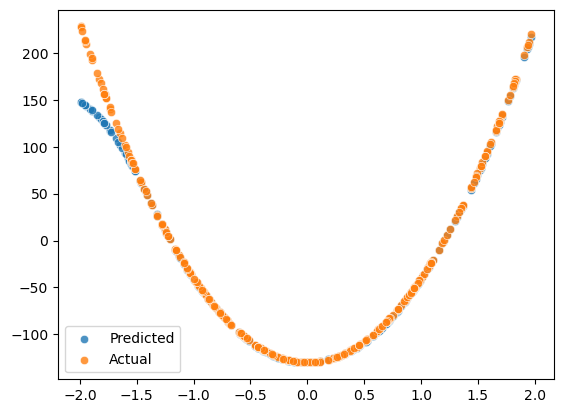

In [176]:
# SQUARE RMSPROP
size = square_large_test.shape[0]
test(square_large_test_X, square_large_test_Y, size, network_151_square_rms)

test mse: 79.76575537270463


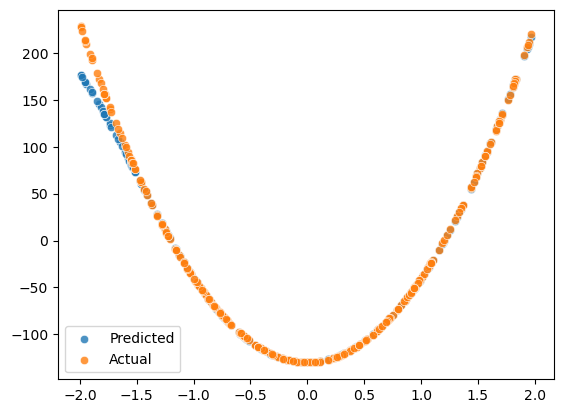

In [177]:
# SQUARE MOMENTUM
size = square_large_test.shape[0]
test(square_large_test_X, square_large_test_Y, size, network_151_square_mom)

Final mse steps_rms:  7.1819093018267335


<Axes: >

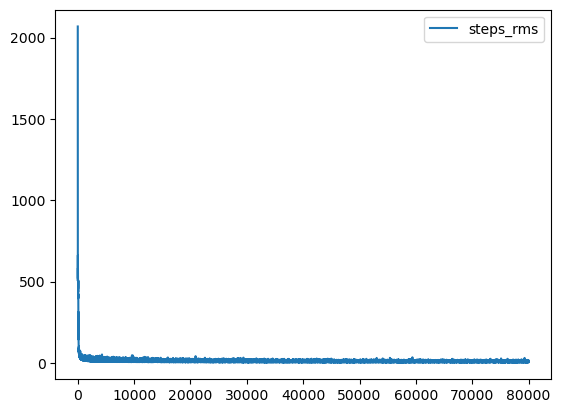

In [355]:
# size: 10000
#18
steps_rms = network(np.array([1, 5, 5, 1]), [None, sigmoid, sigmoid, linear], [None, sigmoid_derivative, sigmoid_derivative,linear_derivative], 'xavier')

steps_rms.learn(steps_large_train, 80000, 0.025, rmsprop_dumping=0.9, batch_size=500)

print('Final mse steps_rms: ', steps_rms.mse_record[-1])

sns.lineplot(steps_rms.mse_record, label = 'steps_rms')

Final mse steps_mom:  2.9531577730409686


<Axes: >

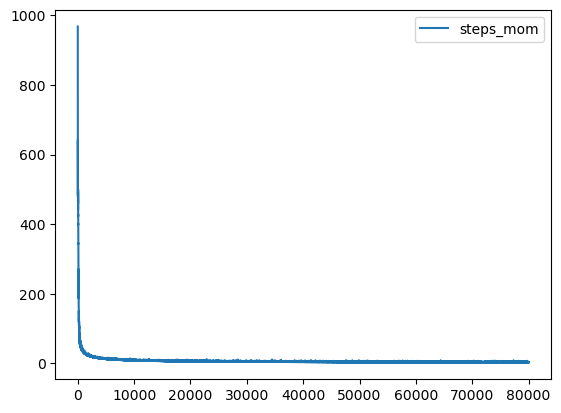

In [352]:
# 10
steps_mom = network(np.array([1, 5, 5, 1]), [None, sigmoid, sigmoid, linear], [None, sigmoid_derivative, sigmoid_derivative,linear_derivative], 'xavier')

steps_mom.learn(steps_large_train, 80000, 0.8, momentum_dumping=0.9, batch_size=500)

print('Final mse steps_mom: ', steps_mom.mse_record[-1])

sns.lineplot(steps_mom.mse_record, label = 'steps_mom')

test mse: 3.30272042965379


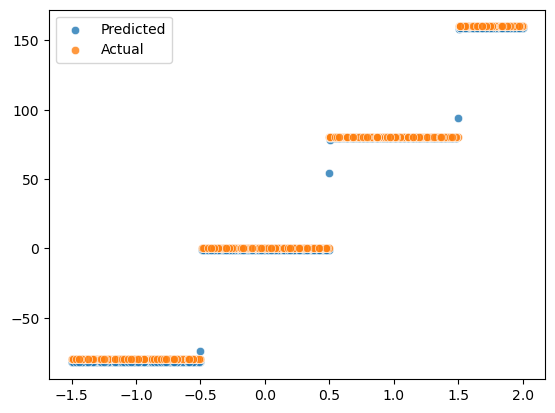

In [356]:
# STEPS RMSPROP
size = steps_large_test.shape[0]
test(steps_large_test_X, steps_large_test_Y, size, steps_rms)

test mse: 2.966282147403025


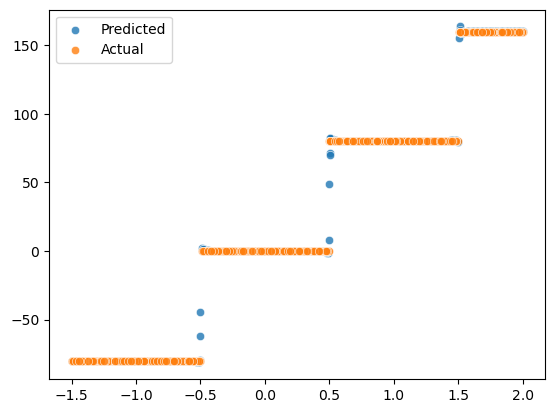

In [357]:
# STEPS MOMENTUM
size = steps_large_test.shape[0]
test(steps_large_test_X, steps_large_test_Y, size, steps_mom)

Final mse network_multimodal_rms:  28.224690410330076


<Axes: >

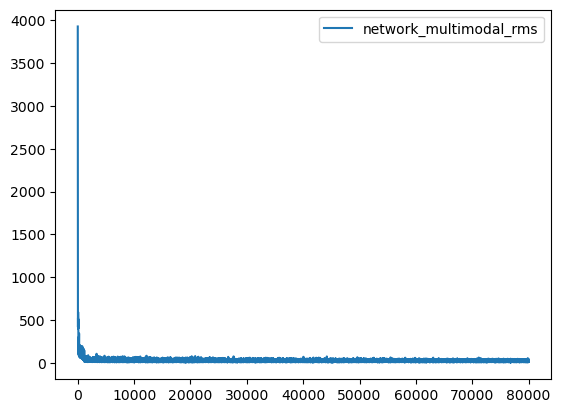

In [354]:
# size: 10000
# 29
network_multimodal_rms = network(np.array([1, 10, 10, 1]), [None, sigmoid, sigmoid, linear], [None, sigmoid_derivative, sigmoid_derivative, linear_derivative], 'xavier')
network_multimodal_rms.learn(multimodal_large_train, 80000, 0.025, rmsprop_dumping=0.9, batch_size=500)

print('Final mse network_multimodal_rms: ', network_multimodal_rms.mse_record[-1])
sns.lineplot(network_multimodal_rms.mse_record, label = 'network_multimodal_rms')

Final mse network_multimodal_mom:  6.407829178801352


<Axes: >

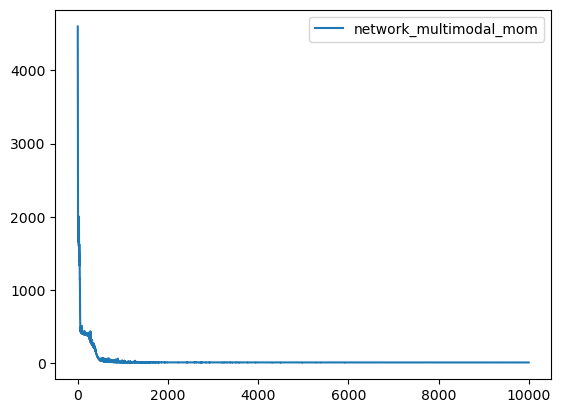

In [333]:
network_multimodal_mom = network(np.array([1, 10, 10, 1]), [None, sigmoid, sigmoid, linear], [None, sigmoid_derivative, sigmoid_derivative, linear_derivative], 'xavier')
network_multimodal_mom.learn(multimodal_large_train, 10000, 0.6, momentum_dumping=0.9, batch_size=1000)

print('Final mse network_multimodal_mom: ', network_multimodal_mom.mse_record[-1])
sns.lineplot(network_multimodal_mom.mse_record, label = 'network_multimodal_mom')

test mse: 28.753050305020444


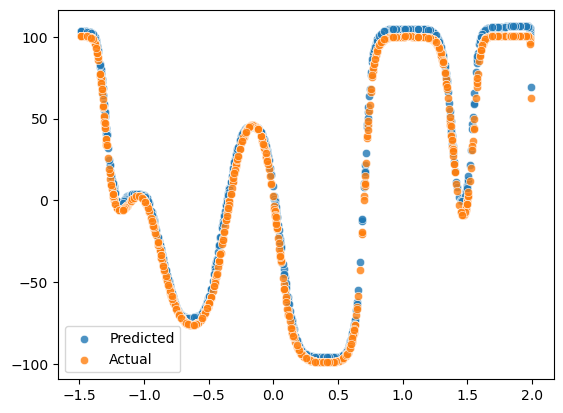

In [358]:
# MULTIMODAL RMSPROP
size = multimodal_large_test.shape[0]
test(multimodal_large_test_X, multimodal_large_test_Y, 1000, network_multimodal_rms)

test mse: 1.973036229724195


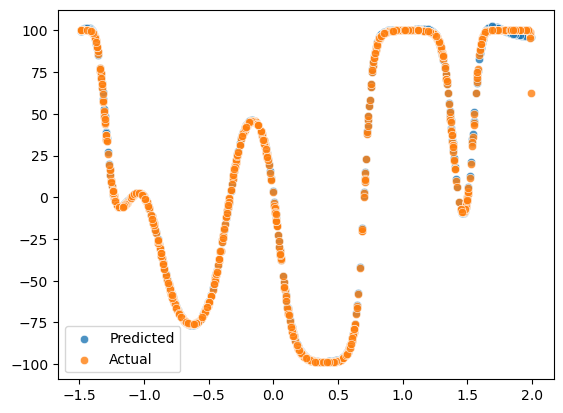

In [349]:
# MULTIMODAL MOMENTUM
size = multimodal_large_test.shape[0]
test(multimodal_large_test_X, multimodal_large_test_Y, 1000, network_multimodal_mom)

In [ ]:
# wnioski
# Ustawianie parametrów dla uczenia z momentem i RMSprop okazuje się trudne. Mimo że użycie RMSprop znacząco przyspiesza początkową zbieżność to uczenie z momentem łatwiej odnajduje docelowy niski błąd. Być może implementacja zawiera jakiś mały błąd, ale szczerze mówiąc dużo łatwiej, przynajmniej z perspektywy szukania parametrów, wyuczyły się sieci z czystą backpropagacją i batchowaniem. Nie udało mi się spełnić warunków MSE na wszystkich zbiorach dla obu: momentu i RMSprop. Ale każdy zbiór ma przynajmniej jedną z tych metod ponieżej wymaganego progu. Szczególnie dla RMSprop zauważyłem tendencję do zaburzania predykcji o bias na ostatnim neuronie (mam wrażenie że jakby nieznacznie podnieść/opuścić wszystkie punkty to pasowało by lepiej).  